In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

dados = pd.read_csv('/content/TelecomX_dados_tratados.csv')

dados.drop(columns=['customerID'], inplace=True)

dados['account.Charges.Total'] = pd.to_numeric(dados['account.Charges.Total'], errors='coerce')
dados.dropna(inplace=True)
dados.head()

,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [24]:
y = dados['Churn']
X = dados.drop(columns='Churn')

In [25]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()


In [26]:
preprocessador = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_cols),
    ('scale', StandardScaler(), num_cols)
])

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [28]:
#Modelo 1: Regressão Logística
pipeline_lr = Pipeline([
    ('preprocess', preprocessador),
    ('modelo', LogisticRegression(max_iter=1000))
])

pipeline_lr.fit(X_treino, y_treino)
y_pred_lr = pipeline_lr.predict(X_teste)


pipeline_lr.score(X_teste, y_teste)

0.8028436018957346

In [30]:
#Modelo 2: Floresta Aleatória (Random Forest)
pipeline_rf = Pipeline([
    ('preprocess', preprocessador),
    ('modelo', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_treino, y_treino)
y_pred_rf = pipeline_rf.predict(X_teste)

pipeline_rf.score(X_teste, y_teste)

0.7881516587677725

In [32]:
print("🔎 Regressão", classification_report(y_teste, y_pred_lr))
print("🔎 Arvore", classification_report(y_teste, y_pred_rf))


🔎 Regressão               precision    recall  f1-score   support

          No       0.84      0.90      0.87      1549
         Yes       0.66      0.54      0.59       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110

🔎 Arvore               precision    recall  f1-score   support

          No       0.83      0.90      0.86      1549
         Yes       0.64      0.48      0.55       561

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.78      0.79      0.78      2110



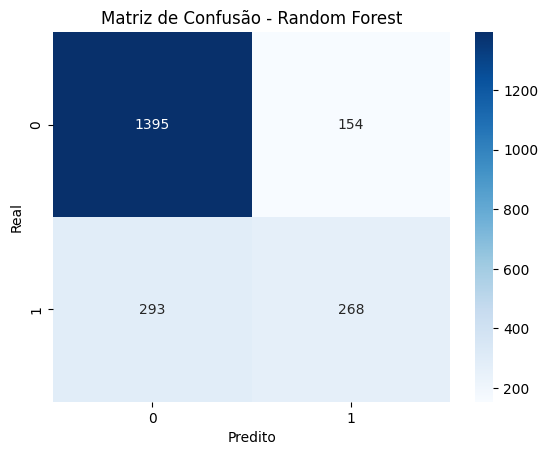

In [33]:
sns.heatmap(confusion_matrix(y_teste, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


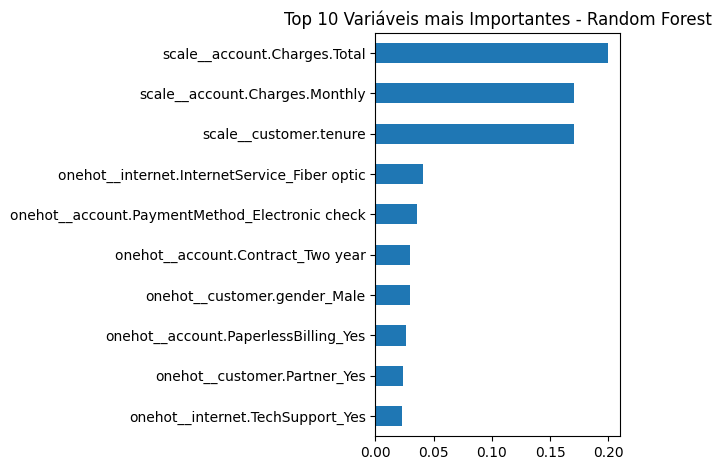

In [36]:
X_encoded = pd.DataFrame(
    preprocessador.fit_transform(X),
    columns = preprocessador.get_feature_names_out()
)

modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_encoded, y)

importancias = pd.Series(modelo_rf.feature_importances_, index=X_encoded.columns)
importancias.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Variáveis mais Importantes - Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [40]:
novo_cliente = pd.DataFrame([{
    'customer.gender': 'Female',
    'customer.SeniorCitizen': True,
    'customer.Partner': 'No',
    'customer.Dependents': 'No',
    'customer.tenure': 5,
    'phone.PhoneService': 'Yes',
    'phone.MultipleLines': 'No',
    'internet.InternetService': 'Fiber optic',
    'internet.OnlineSecurity': 'No',
    'internet.OnlineBackup': 'No',
    'internet.DeviceProtection': 'Yes',
    'internet.TechSupport': 'No',
    'internet.StreamingTV': 'Yes',
    'internet.StreamingMovies': 'Yes',
    'account.Contract': 'Month-to-month',
    'account.PaperlessBilling': 'Yes',
    'account.PaymentMethod': 'Electronic check',
    'account.Charges.Monthly': 89.10,
    'account.Charges.Total': 445.5
}])

In [43]:
predicao = pipeline_rf.predict(novo_cliente)
proba = pipeline_rf.predict_proba(novo_cliente)

print(f"🔍 Previsão: {'Churn' if predicao[0] == 1 else 'Não churn'}")
print(f"📊 Probabilidade de churn: {proba[0][1]*100:.2f}%")


🔍 Previsão: Não churn
📊 Probabilidade de churn: 68.00%
